## Mean SpeedNorm by Relative Box for each Track & Distance

Here we perform a similar analysis as 'speednorm-by-trackdist.ipynb', except instead of using the definite box, we normalise the boxes in the case of outlier scratchings. For example, if Box 1 is empty, then Box 2 now becomes Box 1 (from a performance persepective), Box 3 becomes Box 2, and so on.

----

### 0. Read cleansed data

In [6]:
import os
import decouple
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.ticker as plticker
import math

from scipy.stats import zscore

config = decouple.AutoConfig(' ')
os.chdir(config('ROOT_DIRECTORY'))
sys.path.insert(0, '')

pd.set_option('display.max_columns', None)

# Read in data
df_raw = pd.read_csv('./data/clean/dog_results.csv')
df_raw['RaceDate'] = pd.to_datetime(df_raw['RaceDate'], format='%Y-%m-%d')

display(df_raw.head())

,FasttrackDogId,Place,DogName,Box,Rug,Weight,StartPrice,Margin1,Margin2,PIR,Checks,SplitMargin,RunTime,Prizemoney,FasttrackRaceId,TrainerId,TrainerName,Distance,RaceGrade,Track,RaceNum,TrackDist,RaceDate,FieldSize
0,157500927,1,RAINE ALLEN,1,1,27.4,2.4,2.30,NaN,Q/111,0,6.68,28.66,0.0,335811282,7683,C GRENFELL,500.0,Restricted Win,Bendigo,1.0,Bendigo500,2018-07-01,6
1,1820620018,2,SURF A LOT,2,2,32.8,6.3,2.30,2.30,M/332,0,7.01,28.82,0.0,335811282,137227,C TYLEY,500.0,Restricted Win,Bendigo,1.0,Bendigo500,2018-07-01,6
2,1950680026,3,PINGIN' BEE,6,6,25.5,9.3,3.84,1.54,S/443,0,7.24,28.93,0.0,335811282,132763,P DAPIRAN,500.0,Restricted Win,Bendigo,1.0,Bendigo500,2018-07-01,6
3,1524380048,4,LUCAS THE GREAT,7,7,32.2,9.1,5.27,1.43,M/655,5,7.31,29.03,0.0,335811282,116605,E HAMILTON,500.0,Restricted Win,Bendigo,1.0,Bendigo500,2018-07-01,6
4,124225458,5,QUAVO,4,4,28.9,3.4,5.56,0.29,M/766,8,7.38,29.05,0.0,335811282,132763,P DAPIRAN,500.0,Restricted Win,Bendigo,1.0,Bendigo500,2018-07-01,6


### 1. Analysis

Take a copy of the dataframe, and create a SpeedNorm column (relative to each Track & Distance) as well as a RelativeBox column.

In [7]:
# Copy dataframe
df = df_raw.copy()

# Calculate the average speed of greyhound for each race
df["Speed"] = df["Distance"]/df["RunTime"]

# Normalise the speed by track and distance
df["SpeedNorm"] = df.groupby("TrackDist")["Speed"].transform(lambda x: zscore(x))

# Create a RelativeBox column (scaling box range to (1, 8))
df['RelativeBox'] = df.groupby('FasttrackRaceId')['Box'].transform(lambda x: (x - min(x))/(max(x) - min(x)))
df['RelativeBox'] = df['RelativeBox'].apply(lambda x: int((x*(8-1)) + 1))

display(df)

,FasttrackDogId,Place,DogName,Box,Rug,Weight,StartPrice,Margin1,Margin2,PIR,Checks,SplitMargin,RunTime,Prizemoney,FasttrackRaceId,TrainerId,TrainerName,Distance,RaceGrade,Track,RaceNum,TrackDist,RaceDate,FieldSize,Speed,SpeedNorm,RelativeBox
0,157500927,1,RAINE ALLEN,1,1,27.4,2.4,2.30,NaN,Q/111,0,6.68,28.66,0.0,335811282,7683,C GRENFELL,500.0,Restricted Win,Bendigo,1.0,Bendigo500,2018-07-01,6,17.445918,0.467375,1
1,1820620018,2,SURF A LOT,2,2,32.8,6.3,2.30,2.30,M/332,0,7.01,28.82,0.0,335811282,137227,C TYLEY,500.0,Restricted Win,Bendigo,1.0,Bendigo500,2018-07-01,6,17.349063,0.052453,2
2,1950680026,3,PINGIN' BEE,6,6,25.5,9.3,3.84,1.54,S/443,0,7.24,28.93,0.0,335811282,132763,P DAPIRAN,500.0,Restricted Win,Bendigo,1.0,Bendigo500,2018-07-01,6,17.283097,-0.230144,6
3,1524380048,4,LUCAS THE GREAT,7,7,32.2,9.1,5.27,1.43,M/655,5,7.31,29.03,0.0,335811282,116605,E HAMILTON,500.0,Restricted Win,Bendigo,1.0,Bendigo500,2018-07-01,6,17.223562,-0.485192,7
4,124225458,5,QUAVO,4,4,28.9,3.4,5.56,0.29,M/766,8,7.38,29.05,0.0,335811282,132763,P DAPIRAN,500.0,Restricted Win,Bendigo,1.0,Bendigo500,2018-07-01,6,17.211704,-0.535991,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
782997,491585906,3,GLORIOUS GUNN,8,8,27.1,3.8,3.75,2.43,6644,0,5.70,30.45,395.0,745616339,87891,G HORNE,520.0,Grade 5,Cannington,12.0,Cannington520,2021-12-31,7,17.077176,0.274907,8
782998,485659451,4,WOOD FIRE,3,3,32.1,4.1,3.75,0.14,3233,0,5.58,30.46,145.0,745616339,68549,C HALSE,520.0,Grade 5,Cannington,12.0,Cannington520,2021-12-31,7,17.071569,0.254759,3
782999,528381655,5,TRENDING QUARTER,6,6,31.8,16.2,5.25,1.43,4566,0,5.64,30.56,0.0,745616339,83581,J DAILLY,520.0,Grade 5,Cannington,12.0,Cannington520,2021-12-31,7,17.015707,0.054004,6
783000,537992387,6,ELITE WEAPON,1,1,26.7,2.9,5.25,0.00,1455,0,5.51,30.56,0.0,745616339,293372,S WILLIAMS,520.0,Grade 5,Cannington,12.0,Cannington520,2021-12-31,7,17.015707,0.054004,1


Let's look at weird box combinations

In [10]:
df_temp = df.copy()

df_temp['OutsideBox'] = df_temp.groupby('FasttrackRaceId')['Box'].transform(lambda x: max(x))
df_temp['InsideBox'] = df_temp.groupby('FasttrackRaceId')['Box'].transform(lambda x: min(x))

df_temp = df_temp[df_temp['InsideBox'] == 4]
df_temp = df_temp[['FasttrackRaceId', 'Box', 'RelativeBox', 'InsideBox', 'OutsideBox']]

pd.set_option('display.max_rows', 100)
display(df_temp.sort_values(by=['FasttrackRaceId', 'Box']).head(100))

,FasttrackRaceId,Box,RelativeBox,InsideBox,OutsideBox
30776,352107316,4,1,4,8
30773,352107316,5,2,4,8
30775,352107316,6,4,4,8
30774,352107316,7,6,4,8
30777,352107316,8,8,4,8
38366,356903891,4,1,4,8
38367,356903891,5,2,4,8
38365,356903891,7,6,4,8
38368,356903891,8,8,4,8
73432,374086255,4,1,4,8


Now we will plot the mean SpeedNorm for each Track & Distance (with a large enough sample size) for each relative box.

In [4]:
# Group by track, distance, box and aggregate number of box runs and average
df = df.groupby(["TrackDist", "RelativeBox"], as_index=False).agg(SpeedNorm_mean=('SpeedNorm', 'mean'),
                                                                  SpeedNorm_std=('SpeedNorm', 'std'),
                                                                  SampleSize=('RelativeBox', 'count'))

# Take only trackdist with a large enough sample size
df["MinSampleSize"] = df.groupby("TrackDist")["SampleSize"].transform(lambda x: min(x))
df = df[df["MinSampleSize"] >= 1500]

display(df)

,TrackDist,RelativeBox,SpeedNorm_mean,SpeedNorm_std,SampleSize,MinSampleSize
0,Albion Park331,1,0.178194,0.947902,2252,1967
1,Albion Park331,2,0.101875,0.945398,2150,1967
2,Albion Park331,3,-0.044099,1.010265,2119,1967
3,Albion Park331,4,-0.075431,1.126121,2123,1967
4,Albion Park331,5,-0.060792,0.935877,1991,1967
...,...,...,...,...,...,...
890,Warragul460,4,-0.050228,0.970491,2007,1750
891,Warragul460,5,-0.098933,1.001827,1750,1750
892,Warragul460,6,-0.031601,0.999460,1983,1750
893,Warragul460,7,-0.050258,0.986346,1869,1750


The resulting graph is incredibly similar to the plot in speednorm-by-trackdist.ipynb.

<AxesSubplot:xlabel='RelativeBox', ylabel='SpeedNorm_mean'>

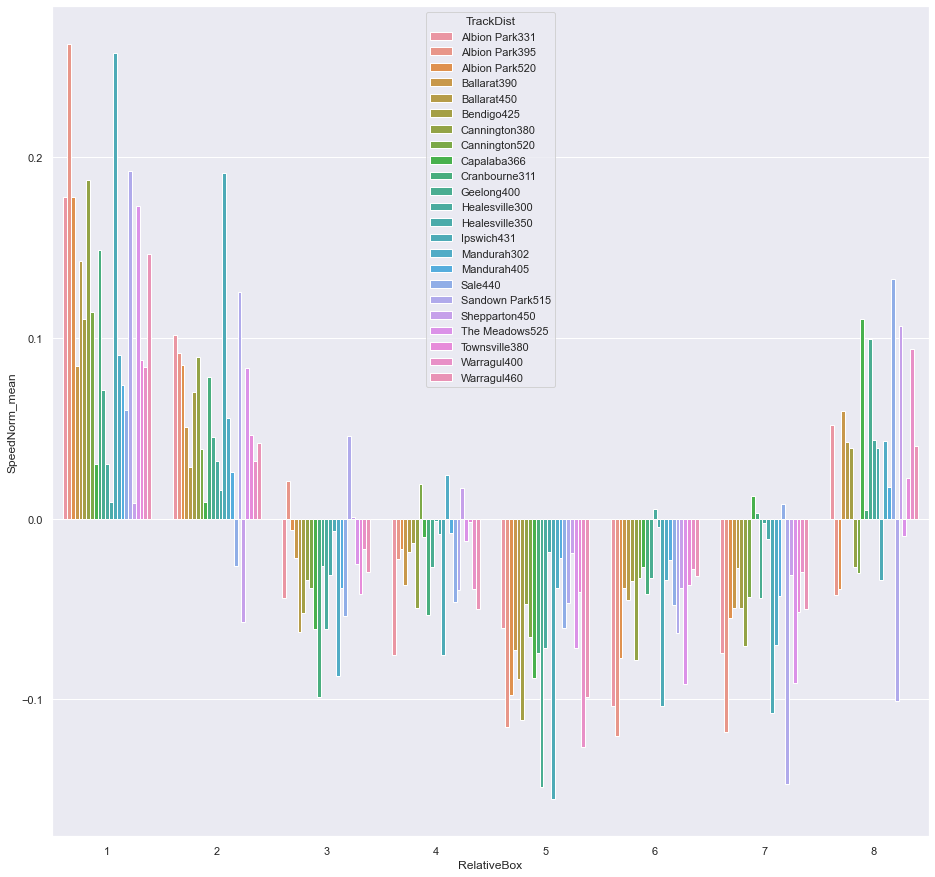

In [5]:
# plot
sns.set_theme()
fig, ax = plt.subplots(figsize=(15.7, 15.27))
plt.rc('xtick',labelsize=15)
plt.rcParams["axes.labelsize"] = 15
plt.rc('ytick',labelsize=15)

sns.barplot(data=df, x="RelativeBox", y="SpeedNorm_mean", hue="TrackDist")